# COCO Image Viewer
This notebook will allow you to view details about a COCO dataset and preview segmentations on annotated images.
Learn more about it at: http://cocodataset.org/

Note: Gist probably won't show the segmentations, but if you run this code in your own Jupyter Notebook, you'll see them.

The rest of the tutorial can be found at: http://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch

In [1]:
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
import base64
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from IPython.display import Image

In [2]:
# Load the dataset json
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                                'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                               'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                               'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()
            
        
    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
            
            buffer = BytesIO()
            image.save(buffer, format='PNG')
            buffer.seek(0)
            
            data_uri = base64.b64encode(buffer.read()).decode('ascii')
            image_path = "data:image/png;base64,{0}".format(data_uri)
            
        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))
            polygons[segm['id']] = polygons_list
            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))
        
        
        
        # Draw segmentation polygons on image
        html  = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(image_path, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
        
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [4]:
annotation_path = '/mnt/data2/datasets/detr/temp/Z17/object_detection/annotations/custom_train.json'
image_dir = '/mnt/data2/datasets/detr/temp/Z17/object_detection/train_val2017/'

coco_dataset = CocoDataset(annotation_path, image_dir)
coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()

Dataset Info:
  description: Body_panoptic_segmentation
  url: cab.se
  version: 0.2.0
  year: 2020
  contributor: CAB
  date_created: 2020-10-19 09:08:50.897250

Licenses:
  id: 1
  name: Fake License
  url: http://creativefakeys.org/licenses/by-nc-sa/2.0/


Categories:
  super_category: car_part
    id 0: grill
    id 1: front_bumper
    id 2: hood
    id 3: left_headlight
    id 4: right_headlight
    id 5: left_front_fender
    id 6: right_front_fender
    id 7: left_rearview_mirror
    id 8: right_rearview_mirror
    id 9: left_front_door
    id 10: right_front_door
    id 11: left_rear_door
    id 12: right_rear_door
    id 13: left_sill
    id 14: right_sill
    id 15: left_rear_panel
    id 16: right_rear_panel
    id 17: rear_bumper
    id 18: lower_tailgate
    id 19: upper_tailgate

  super_category: wheels
    id 20: left_front_wheel
    id 21: right_front_wheel
    id 22: left_rear_wheel
    id 23: right_rear_wheel

  super_category: background
    id 24: not_car



In [5]:
print(coco_dataset.images[1])
res = np.array([list(item.values()) for item in coco_dataset.images.values()])


{'id': 1, 'file_name': '11.jpg', 'width': 1585, 'height': 2114, 'date_captured': '2020-10-19 06:27:35.597696', 'license': 1, 'coco_url': '', 'flickr_url': ''}


In [6]:
res1 =  res[res[:,1].argsort()] 
# reverse order = res[res[:,1].argsort()[::-1]]


print(res1)


[['14' '00.jpg' '1280' '960' '2020-10-19 06:27:35.597696' '1' '' '']
 ['17' '01.jpg' '1057' '793' '2020-10-19 06:27:35.597696' '1' '' '']
 ['3' '02.jpg' '1280' '960' '2020-10-19 06:27:35.597696' '1' '' '']
 ['12' '03.jpg' '1280' '960' '2020-10-19 06:27:35.597696' '1' '' '']
 ['5' '04.jpg' '480' '640' '2020-10-19 06:27:35.597696' '1' '' '']
 ['15' '05.jpg' '1280' '960' '2020-10-19 06:27:35.597696' '1' '' '']
 ['4' '06.jpg' '713' '950' '2020-10-19 06:27:35.597696' '1' '' '']
 ['2' '07.jpg' '1280' '960' '2020-10-19 06:27:35.597696' '1' '' '']
 ['10' '08.jpg' '1024' '768' '2020-10-19 06:27:35.597696' '1' '' '']
 ['6' '09.jpg' '1337' '1003' '2020-10-19 06:27:35.597696' '1' '' '']
 ['13' '10.jpg' '1280' '960' '2020-10-19 06:27:35.597696' '1' '' '']
 ['1' '11.jpg' '1585' '2114' '2020-10-19 06:27:35.597696' '1' '' '']
 ['16' '12.jpg' '1280' '960' '2020-10-19 06:27:35.597696' '1' '' '']
 ['8' '13.jpg' '1280' '960' '2020-10-19 06:27:35.597696' '1' '' '']
 ['7' '14.jpg' '1280' '960' '2020-10-19 0

Image:
  id: 9
  file_name: 16.jpg
  width: 1280
  height: 960
  date_captured: 2020-10-19 06:27:35.597696
  license: 1
  coco_url: 
  flickr_url: 
  segmentations (7):
    43:blue:{'id': 24, 'name': 'not_car', 'supercategory': 'background', 'isthing': 1}
    1:purple:{'id': 10, 'name': 'right_front_door', 'supercategory': 'car_part', 'isthing': 1}
    7:red:{'id': 17, 'name': 'rear_bumper', 'supercategory': 'car_part', 'isthing': 1}
    61:green:{'id': 12, 'name': 'right_rear_door', 'supercategory': 'car_part', 'isthing': 1}
    31:orange:{'id': 23, 'name': 'right_rear_wheel', 'supercategory': 'wheels', 'isthing': 1}
    27:salmon:{'id': 16, 'name': 'right_rear_panel', 'supercategory': 'car_part', 'isthing': 1}
    108:pink:{'id': 14, 'name': 'right_sill', 'supercategory': 'car_part', 'isthing': 1}



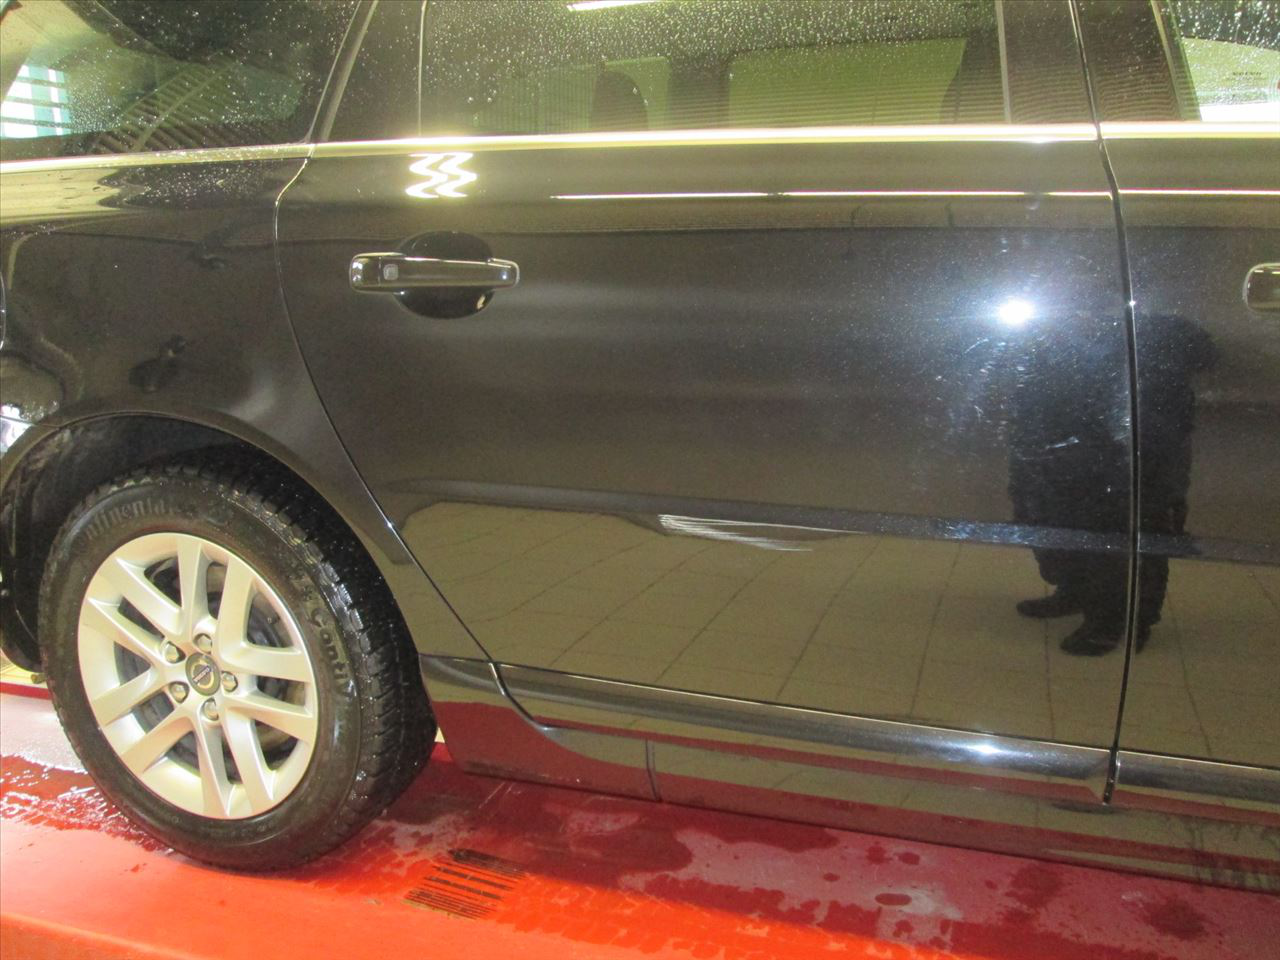

In [16]:

html = coco_dataset.display_image(9, use_url=False)
IPython.display.HTML(html)


# Sample Annotations JSON
Below are the contents of 'sample_annotations.json'.

In [38]:
with open(annotation_path) as json_file:
    lines = json_file.readlines()
for line in lines:
    print(line)

{"info": {"description": "Door_object_panoptic_segmentation", "url": "cab.se", "version": "0.1.0", "year": 2020, "contributor": "Cab", "date_created": "2020-09-24 13:39:12.647278"}, "licenses": [{"id": 1, "name": "Fake License", "url": "http://creativefakeys.org/licenses/by-nc-sa/2.0/"}], "categories": [{"id": 0, "name": "front_door", "supercategory": "door"}, {"id": 1, "name": "rear_door", "supercategory": "door"}, {"id": 2, "name": "not_door", "supercategory": "background"}], "images": [{"id": 1, "file_name": "a074.jpg", "width": 1280, "height": 960, "date_captured": "2020-09-24 13:19:29.720136", "license": 1, "coco_url": "", "flickr_url": ""}, {"id": 2, "file_name": "145.jpg", "width": 1280, "height": 960, "date_captured": "2020-09-24 13:19:29.720136", "license": 1, "coco_url": "", "flickr_url": ""}, {"id": 3, "file_name": "181.jpg", "width": 1024, "height": 768, "date_captured": "2020-09-24 13:19:29.720136", "license": 1, "coco_url": "", "flickr_url": ""}, {"id": 4, "file_name": "0

In [39]:
res[0]

array(['1', 'a074.jpg', '1280', '960', '2020-09-24 13:19:29.720136', '1',
       '', ''], dtype='<U26')